In [1]:
from modules.utils import scrape, read, get_vocab
import modules.viz_utils as viz

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import random
import sys
plt.style.use('bmh')
sys.setrecursionlimit(115)

# Loading

In [2]:
URL = 'https://finviz.com/news.ashx'


scraped_df = scrape(URL)
loaded_df = read()

df = get_vocab(loaded_df)

In [3]:
data = df.copy()
data.head()

,Unnamed: 0,title,agency,date,vocab
0,0,"['US STOCKS-Wall Street slides as Intel dives,...",https://www.reuters.com/article/usa-stocks/us-...,2020-07-24,"[street, slides, intel, dives, earnings, pande..."
1,1,['UPDATE 2-Chilean health minister sets gradua...,https://www.reuters.com/article/health-coronav...,2020-07-24,"[chilean, health, minister, gradual, lifting, ..."
2,2,"['Wall Street slides as Intel dives, earnings ...",https://www.reuters.com/article/us-usa-stocks/...,2020-07-24,"[street, slides, intel, dives, earnings, pande..."
3,3,"[""Wall Street bull: Fed liquidity 'punch bowl'...",https://video.foxbusiness.com/v/6174747002001/,2020-07-24,"[street, liquidity, punch, poses, risks, marke..."
4,4,['Gold surges to record close as U.S.-China te...,https://www.cnbc.com/2020/07/24/gold-surges-to...,2020-07-24,"[surges, record, close, uschina, tensions, esc..."


# Analysis

#### Character Length of Vocab

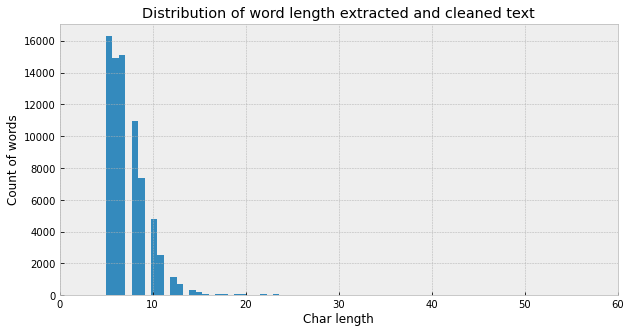

In [4]:
w_len = viz.char_length_distr(data)

fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (10,5))
ax.hist(w_len, bins = 100)
ax.set_xlim(0,60)
ax.set_title('Distribution of word length extracted and cleaned text');
ax.set_xlabel('Char length');
ax.set_ylabel('Count of words');

#### Removing large words

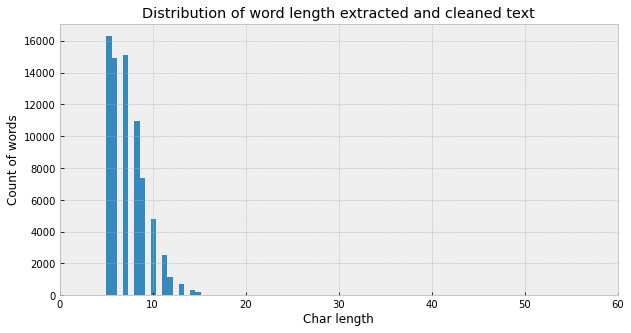

In [5]:
w_len = viz.char_length_distr(viz.remove_large_words(data))

fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (10,5))
ax.hist(w_len, bins = 50)
ax.set_xlim(0,60)
ax.set_title('Distribution of word length extracted and cleaned text');
ax.set_xlabel('Char length');
ax.set_ylabel('Count of words');


#### Token Frequency

In [8]:
def get_token_freq(list_of_tokens):
    # Calculate word frequency
    token_freq = {}
    for token in list_of_tokens:
        token_freq[token] =  token_freq.get(token, 0) + 1
    return token_freq

def get_token_freq_of_corpus(series_of_token_lists):
    # Calculate word frequency
    token_freq = {}
    for list_of_tokens in series_of_token_lists:
        for token in list_of_tokens:
            token_freq[token] =  token_freq.get(token, 0) + 1
    return token_freq

freq_list = []
for news_article_vocab in data['vocab']:
    freq_list.append(get_token_freq(news_article_vocab))
    
    
freq_df = pd.DataFrame(freq_list)


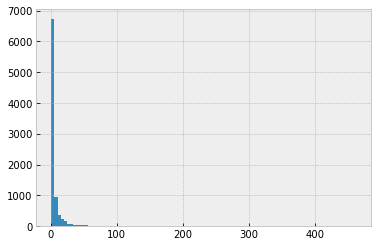

In [9]:
plt.hist(freq_df.sum().values, bins = 100);

# TF-IDF

In [10]:
#Get the docs set up
docs = []
for l in data['vocab']:
    doc = ' '.join(l)
    docs.append(doc)


In [11]:

Tfidf=TfidfVectorizer(ngram_range=(1,1))
TFIDF_matrix=Tfidf.fit_transform(docs)     
#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names())



In [12]:
#Cumulative TF-IDF
matrix.sum().sort_values()[-5:]


robot       5.587265
stock       6.483873
please      6.699688
trading     6.851630
reuters    10.391740
dtype: float64

In [13]:
k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()

In [14]:
data['cluster'] = clusters

# //TODO Clustering Visualization

# Word2Vec


1. Learn internal weights
- X: context (k words on either side)
- y: word


In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import BatchNormalization

import seaborn as sns
print(keras.__version__)
print(tf.__version__)

2.3.0-tf
2.2.0


In [17]:
def get_global_vocab(df):
    words = []
    for V in df['vocab']:
        for i,word in enumerate(V):
            words.append(word)
    return set(words)


def get_translate_dicts(words):
    word_indices = dict((c, i) for i, c in enumerate(words))
    indices_word = dict((i, c) for i, c in enumerate(words))
    return word_indices, indices_word



global_words = get_global_vocab(data)
encoder, decoder = get_translate_dicts(global_words)
    

In [18]:
# WIndow size
K = 15

def get_global_training_values(df, k):
    
    context = []
    W = []
    
    for V in df['vocab']:
        for i,word in enumerate(V):
#             if (i < k)| (len(V) < i+1+k):
#                 continue
            behind = V[i-k : i] 
            infront = V[i+1 : i+k+1]

            context.append((behind+infront))
            W.append(word)

        return context, W
        

    
    
C_, W_ = get_global_training_values(data, K)    

In [19]:
def convert_training_to_numeric(c,w):
        
    context = []
    W = []
    
    #Context
    for doc in c:
        doc_context = []
        for word in doc:
            doc_context.append(encoder[word])
        context.append(doc_context)
    
    #Word
    for word in w:
        W.append(encoder[word])

    return context, W
     
    
C, W = convert_training_to_numeric(C_,W_)    

In [20]:
#Need to pad C before converting to array
#Most common 8325 == REUTERS
for candidate in C:
    if len(candidate) < K*2:
        #Pad
        candidate.extend([random.randint(0,len(encoder)) for i in range(K*2 - len(candidate))])

The contexts need to be one hot vectors in and 2d in the sense that it is a binary target for the objective function. "Is this word present in the context or not"


$L$ $:$ $f(C_{i,j},W$) --> Binary



In [21]:
def flat_c_w(c,w):
    
    U = []
    V = []
    for sublist, word in zip(c,w):
        for value in sublist:
            U.append(value)
            V.append(word)
    return U,V

#List of tuples to be sampled from
S_c, S_w = flat_c_w(C,W)

In [22]:
S_universe = np.array(list(set(S_c+S_w)))

def generator(s_c, s_w, S_universe, batch_size, p = .5  ):
    
    batch_contexts = np.zeros((batch_size, 1, len(encoder)))
    #batch_words = np.zeros((batch_size, 1, len(encoder)))
    batch_labels = np.zeros((batch_size,len(encoder)))
    while True:
        for i in range(batch_size):
            c = list(zip(s_c, s_w))
            candidate_1 = np.random.choice(S_universe)
            candidate_2 = np.random.choice(S_universe)
            x = (candidate_1, candidate_2)

            if np.random.binomial(1,p):
                r = np.random.randint(0,len(c))
                batch_contexts[i] = tf.keras.utils.to_categorical(c[r][0],  num_classes = len(encoder))
                batch_labels[i] = tf.keras.utils.to_categorical(c[r][1],  num_classes = len(encoder))
                continue
            if x not in c:

                batch_contexts[i] = tf.keras.utils.to_categorical(x[0], num_classes = len(encoder))
                batch_labels[i]= np.zeros(len(encoder))#tf.keras.utils.to_categorical(0, num_classes = len(encoder))
                continue

        yield batch_contexts, batch_labels



In [23]:
pd.DataFrame(next(generator(S_c,S_w, S_universe, 10, .3))[1]).sum(axis=1)

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    1.0
dtype: float64

In [24]:
INPUT_SHAPE = (len(encoder),)
EMBEDDING_SIZE = 50

model = models.Sequential()
model.add(layers.Dense(EMBEDDING_SIZE, input_shape=INPUT_SHAPE)) # 1 hidden layer node
model.add(layers.Activation(activations.tanh))
model.add(layers.Dense(len(encoder), activation='softmax')) #softmax for multiclass classification



In [33]:
# For use with non-categorical labels
#model.compile(optimizer='adam',           
model.compile(optimizer=keras.optimizers.SGD(lr=.01),
                loss='binary_crossentropy',
                metrics=['accuracy'])
epochs = 350
BATCH_SIZE = 128

# train the network
H = model.fit(generator(S_c,S_w, S_universe, BATCH_SIZE, .3),
                        steps_per_epoch = 25,
                        epochs=epochs, verbose = 1)

model.save("model.h5")
print("Saved model to disk")

Epoch 1/350


25/25 [==============================] - 29s 1s/step - loss: 4.1047e-04 - accuracy: 0.0000e+00
Epoch 2/350
25/25 [==============================] - 29s 1s/step - loss: 4.2969e-04 - accuracy: 0.0000e+00
Epoch 3/350
25/25 [==============================] - 28s 1s/step - loss: 4.1709e-04 - accuracy: 0.0000e+00
Epoch 4/350
25/25 [==============================] - 28s 1s/step - loss: 4.2055e-04 - accuracy: 0.0000e+00
Epoch 5/350
25/25 [==============================] - 28s 1s/step - loss: 4.1741e-04 - accuracy: 0.0000e+00
Epoch 6/350
25/25 [==============================] - 28s 1s/step - loss: 4.2307e-04 - accuracy: 0.0000e+00
Epoch 7/350
25/25 [==============================] - 28s 1s/step - loss: 4.2748e-04 - accuracy: 0.0000e+00
Epoch 8/350
25/25 [==============================] - 28s 1s/step - loss: 4.1268e-04 - accuracy: 0.0000e+00
Epoch 9/350
25/25 [==============================] - 28s 1s/step - loss: 4.2780e-04 - accuracy: 0.0000e+00
Epoch 10/350
25/25 [=============================

In [34]:
model.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(9032, 50) dtype=float32, numpy=
 array([[-1.8139618e-02,  2.4402788e-02, -7.5581502e-03, ...,
          2.6893243e-03, -2.1311682e-02,  2.4225691e-02],
        [-2.3376210e-02,  2.5258834e-02,  8.4843487e-05, ...,
          2.4239382e-02,  3.6627892e-03,  2.4697559e-02],
        [-1.5592190e-02,  6.4019952e-03, -9.8107439e-03, ...,
         -2.3274472e-02, -2.7863923e-03,  2.0222997e-02],
        ...,
        [-5.2787289e-03, -6.1296374e-03,  2.3953384e-02, ...,
         -2.0540137e-02, -7.8313965e-03, -4.5836903e-04],
        [-2.1959279e-02,  5.8397371e-03, -6.0896762e-03, ...,
         -4.5998599e-03, -2.4439463e-02,  1.5569890e-02],
        [-1.9896081e-02,  4.3242909e-03,  2.1782709e-02, ...,
         -8.0316197e-03,  1.4968561e-02,  1.6533447e-02]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(50,) dtype=float32, numpy=
 array([ 2.9182903e-04,  2.4234652e-04, -1.6279469e-04,  1.0718355e-03,
        -1.1790828e-03,  1.5122641e-03,  1.2

In [35]:
embedding = model.layers[0].weights[0].numpy()

In [36]:
d = pd.DataFrame(embedding)

In [37]:
d['decoded'] = d.reset_index()['index'].apply(lambda x: decoder[x])

In [55]:
d

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,decoded
0,-0.018140,0.024403,-0.007558,-0.012546,-0.009227,-0.013111,0.012438,-0.003753,0.022154,-0.017056,...,0.022299,0.008148,0.014013,0.004755,-0.024324,-0.018321,0.002689,-0.021312,0.024226,gross
1,-0.023376,0.025259,0.000085,-0.022774,-0.007534,0.000115,-0.011853,-0.018871,0.000448,0.003744,...,-0.019763,-0.013018,-0.003511,-0.016081,0.004303,0.022068,0.024239,0.003663,0.024698,behalf
2,-0.015592,0.006402,-0.009811,0.011261,0.011657,-0.007761,0.024363,0.020707,-0.018544,-0.015327,...,0.003172,0.003275,0.024949,0.015629,-0.024371,0.010066,-0.023274,-0.002786,0.020223,affirm
3,-0.005216,-0.017857,-0.019541,-0.012459,0.010010,-0.015166,0.009580,0.004701,0.022503,-0.015820,...,-0.008807,0.022748,-0.024927,-0.012761,0.016814,-0.012842,0.007235,0.000166,0.003714,river
4,-0.025314,-0.022601,-0.008433,-0.013238,-0.012138,0.017648,0.016703,-0.005936,-0.002355,0.000030,...,-0.002569,-0.006681,-0.012590,-0.011081,-0.012117,-0.001767,-0.009355,-0.017566,0.018602,swiss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9027,0.015999,0.020510,0.011970,-0.024044,-0.006687,-0.016426,0.001359,-0.017299,-0.017284,0.004711,...,0.014365,0.004077,0.017917,0.018661,-0.006165,-0.002610,-0.013849,-0.014005,-0.010864,silliness
9028,-0.006152,-0.018280,0.022993,-0.000597,0.009385,0.004860,0.008916,0.000871,0.014750,0.019753,...,0.018138,-0.006676,0.009762,0.016268,0.017574,-0.003008,0.014249,0.022697,0.020255,moneyist
9029,-0.005279,-0.006130,0.023953,0.010212,0.023409,0.022116,0.011913,-0.025184,-0.022967,-0.016942,...,0.009643,0.008458,-0.009669,-0.004230,-0.020947,0.019078,-0.020540,-0.007831,-0.000458,overly
9030,-0.021959,0.005840,-0.006090,0.016153,0.003525,0.015842,0.013044,0.007824,-0.024142,0.000507,...,-0.010132,0.014002,0.021278,-0.004281,-0.019649,-0.002323,-0.004600,-0.024439,0.015570,transit


(50.0, -0.5)

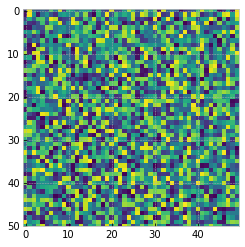

In [56]:
plt.imshow(d.iloc[:,:-1].values)
plt.ylim(50)

dict_keys(['loss', 'accuracy'])

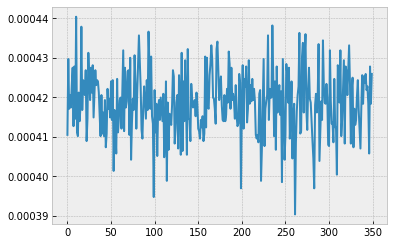

In [57]:
plt.plot(H.history['loss'])
#plt.plot(H.history['val_loss'])

H.history.keys()

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE()
z = tsne.fit_transform(d.iloc[:,:-1])
z

array([[  1.5523041 , -17.700195  ],
       [ 16.4765    ,   4.729212  ],
       [ 19.746542  ,  54.1527    ],
       ...,
       [  6.636472  ,  -1.342344  ],
       [ 12.002225  ,  -0.24816297],
       [ 29.402983  ,  39.63748   ]], dtype=float32)

In [53]:
encoder['cosmo'], encoder['living']

(6438, 3819)

In [46]:
decoder[6438], decoder[3819]

('cosmo', 'living')

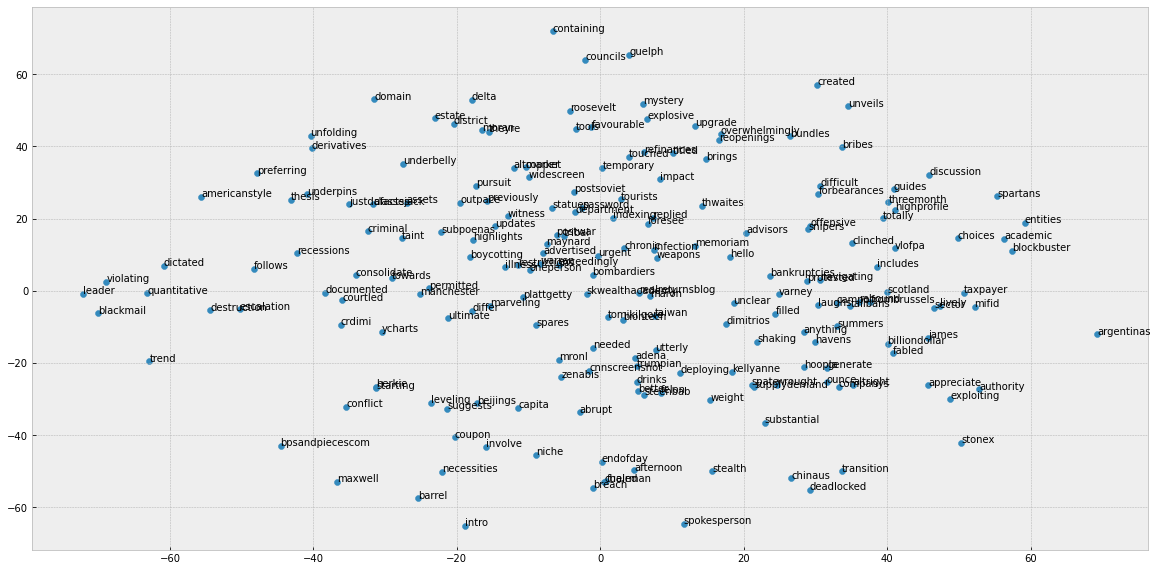

In [76]:
n = 200
x = z[n:n+n,0]
y = z[n:n+n,1]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax.scatter(x, y, zorder = 1)

for i, txt in enumerate(d.iloc[n:n+n,-1]):
    ax.annotate(txt, (x[i], y[i]))

# Prediction Sanity Check

In [494]:
C_binary[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [148]:
print("First C: ", C[0])
print(decoder[C[0][0]], decoder[C[0][1]], decoder[C[0][2]], decoder[C[0][3]])

First C:  [3176, 6164, 413, 2962, 4662, 3356, 822, 3083, 3314, 822, 8106, 5856, 6606, 5333, 822, 3760, 8400, 3812, 1643, 2433, 435, 1197, 8209, 3225, 8275, 2232, 2065, 3219, 685, 3090]
fiscal stimulus hopes offset
